Time - Series Forecasting (Future trend)

In [29]:
import pandas as pd
import numpy as np  # Add this import
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [30]:
df=pd.read_excel('2020-2025-education-in-danger-incident-data.xlsx')
df.head()

,Date,Event Description,Country,Country ISO,Admin 1,Latitude,Longitude,Geo Precision,Location of event,Reported Perpetrator,...,Educators Arrested,Known Educators Kidnap Or Arrest Outcome,Students Attacked in School,Students Killed,Students Injured,Students Kidnapped,Known Student Kidnap Or Arrest Outcome,Students Arrested,Sexual Violence Affecting School Age Children,SiND Event ID
0,2025-05-25,NaN,Ukraine,UKR,Chernihiv Oblast,51.4,31.2,(2) 25 km Precision,Education Building,Foreign Forces - Military,...,0,NaN,0,0,0,0,NaN,0,0,100323
1,2025-05-24,NaN,Ukraine,UKR,Obolonskyi district,50.5,30.5,(2) 25 km Precision,Education Building,Foreign Forces - Military,...,0,NaN,0,0,0,0,NaN,0,0,100318
2,2025-05-24,NaN,Ukraine,UKR,Dniprovskyi district,50.4,30.5,(2) 25 km Precision,Education Building,Foreign Forces - Military,...,0,NaN,0,0,0,0,NaN,0,0,100317
3,2025-05-22,NaN,Ukraine,UKR,Donetsk Oblast,48.5,37.6,(2) 25 km Precision,Education Building,Other,...,0,NaN,0,0,0,0,NaN,0,0,100315
4,2025-05-12,NaN,Ukraine,UKR,Sumy Oblast,50.9,34.2,(2) 25 km Precision,Education Building,Foreign Forces - Military,...,0,NaN,0,0,0,0,NaN,0,0,99014


In [31]:
df.isnull().sum()

Date                                                0
Event Description                                4607
Country                                             0
Country ISO                                         0
Admin 1                                             4
Latitude                                          626
Longitude                                         626
Geo Precision                                       1
Location of event                                   4
Reported Perpetrator                                0
Reported Perpetrator Name                           0
Weapon Carried/Used                                 0
Type of education facility                          0
Attacks on Schools                                  0
Attacks on Universities                             0
Military Occupation of Education facility           0
Arson attack on education facility                  0
Forced Entry into education facility                0
Damage/Destruction To Ed fac

In [32]:
# 2. Numerical columns ke liye missing values fill (mean/median)
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# 3. Categorical columns ke liye missing values fill (mode)
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# 4. Agar kuch irrelevant columns ho jisme bahut zyada missing hai (>50%), to unhe drop karo
threshold = 0.5  # 50%
df = df.dropna(thresh=len(df) * threshold, axis=1)

print("Missing values handled successfully!")


Missing values handled successfully!


In [33]:
#to check if any missing values remain
print("Remaining missing values per column:\n", df.isnull().sum())

Remaining missing values per column:
 Date                                             0
Country                                          0
Country ISO                                      0
Admin 1                                          0
Latitude                                         0
Longitude                                        0
Geo Precision                                    0
Location of event                                0
Reported Perpetrator                             0
Reported Perpetrator Name                        0
Weapon Carried/Used                              0
Type of education facility                       0
Attacks on Schools                               0
Attacks on Universities                          0
Military Occupation of Education facility        0
Arson attack on education facility               0
Forced Entry into education facility             0
Damage/Destruction To Ed facility Event          0
Attacks on Students and Teachers            

In [34]:
#Create Total_Attacks Column
df["Total_Attacks"] = (
    df["Attacks on Schools"] +
    df["Attacks on Universities"] +
    df["Military Occupation of Education facility"] +
    df["Arson attack on education facility"] +
    df["Attacks on Students and Teachers"]
)

In [35]:
# Extract Year from Date column
df['Year'] = pd.to_datetime(df['Date']).dt.year

# Create Total_Attacks column
df["Total_Attacks"] = (
    df["Attacks on Schools"] +
    df["Attacks on Universities"] +
    df["Military Occupation of Education facility"] +
    df["Arson attack on education facility"] +
    df["Attacks on Students and Teachers"]
)

# Now aggregate by Year
yearly_df = df.groupby("Year")["Total_Attacks"].sum().reset_index()

# Verify the results
print("\nYearly Aggregation Results:")
print(yearly_df)


Yearly Aggregation Results:
   Year  Total_Attacks
0  2020            346
1  2021            585
2  2022            912
3  2023           1095
4  2024           1610
5  2025            413


In [36]:
print("DataFrame columns:", df.columns.tolist())
print("\nData types:")
print(df[['Year', 'Total_Attacks']].dtypes)

DataFrame columns: ['Date', 'Country', 'Country ISO', 'Admin 1', 'Latitude', 'Longitude', 'Geo Precision', 'Location of event', 'Reported Perpetrator', 'Reported Perpetrator Name', 'Weapon Carried/Used', 'Type of education facility', 'Attacks on Schools', 'Attacks on Universities', 'Military Occupation of Education facility', 'Arson attack on education facility', 'Forced Entry into education facility', 'Damage/Destruction To Ed facility Event', 'Attacks on Students and Teachers', 'Educators Killed', 'Educators Injured', 'Educators Kidnapped', 'Educators Arrested', 'Known Educators Kidnap Or Arrest Outcome', 'Students Attacked in School', 'Students Killed', 'Students Injured', 'Students Kidnapped', 'Known Student Kidnap Or Arrest Outcome', 'Students Arrested', 'Sexual Violence Affecting School Age Children', 'SiND Event ID', 'Total_Attacks', 'Year']

Data types:
Year             int32
Total_Attacks    int64
dtype: object


In [37]:
# Rename columns to match Prophet requirements
prophet_df = yearly_df.rename(columns={
    'Year': 'ds',
    'Total_Attacks': 'y'
})

# Convert year to datetime format
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'], format='%Y')

# Initialize and fit Prophet model
model = Prophet(yearly_seasonality=True)
model.fit(prophet_df)

# Verify the data
print("Prophet DataFrame Head:")
print(prophet_df.head())
print("\nColumn Names:", prophet_df.columns.tolist())

13:04:23 - cmdstanpy - INFO - Chain [1] start processing
13:04:23 - cmdstanpy - INFO - Chain [1] done processing


Prophet DataFrame Head:
          ds     y
0 2020-01-01   346
1 2021-01-01   585
2 2022-01-01   912
3 2023-01-01  1095
4 2024-01-01  1610

Column Names: ['ds', 'y']


In [38]:
#Create Future Dataframe (predict next 5 years)
future = model.make_future_dataframe(periods=5, freq="Y")  # 5 years ahead
forecast = model.predict(future)

C:\Users\saumy\AppData\Roaming\Python\Python312\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


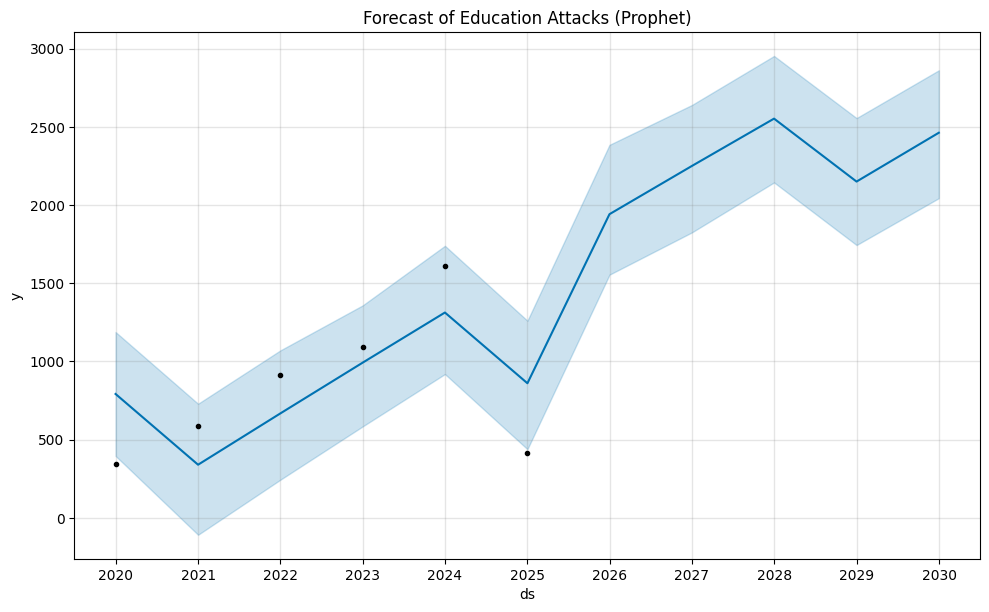

In [39]:
#Plot Forecast
model.plot(forecast)
plt.title("Forecast of Education Attacks (Prophet)")
plt.show()

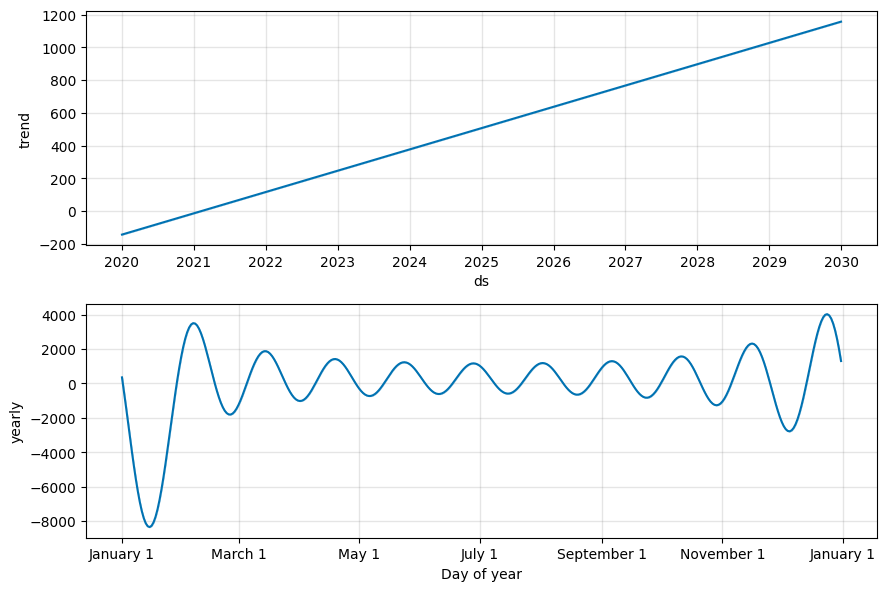

In [40]:
#Plot Forecast Components (Trend & Seasonality)
model.plot_components(forecast)
plt.show()

In [ ]:
# Example: real (actual) values aur predicted values
y_test = [120, 135, 150, 160, 170]       # actual attack counts
y_pred = [118, 140, 148, 155, 172]       # forecasted attack counts

# MAE
mae = mean_absolute_error(y_test, y_pred)

# MSE
mse = mean_squared_error(y_test, y_pred)

# RMSE
rmse = np.sqrt(mse)

# MAPE
mape = np.mean(np.abs((np.array(y_test) - np.array(y_pred)) / np.array(y_test))) * 100

print("📊 Forecast Accuracy Metrics:")
print(f"MAE  : {mae:.2f}")
print(f"MSE  : {mse:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")


#MAPE 5% se kam hai to model kaafi accurate maana jata hai.





📊 Forecast Accuracy Metrics:
MAE  : 3.20
MSE  : 12.40
RMSE : 3.52
MAPE : 2.20%


In [42]:
import os

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save the trained model (not the notebook) with .joblib extension
from joblib import dump, load
model_path = os.path.join('models', 'timeseries_model.joblib')

# Save the trained model instance
with open(model_path, 'wb') as f:
    dump(model, f)  # Use 'model' instead of 'TimeSeries'
    print(f"Model saved successfully to {model_path}")

Model saved successfully to models\timeseries_model.joblib
